In [5]:
from hestonpy.models.heston import Heston
from hestonpy.models.calibration.volatilitySmile import VolatilitySmile
from hestonpy.option.data import get_options_data, filter_data_for_maturity

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

fontdict_title = {
    'fontsize': 20,
    'fontweight': 'bold'
    }
from datetime import datetime
import numpy as np

# Calibration of Heston models on market data

We will calibrate our models on S&P smiles. You can also try with Apple, but there is less liquidity on the market, so less available maturities. Some parameters,

In [6]:
symbol = '^SPX'
all_market_data, spot, maturities = get_options_data(symbol)
if symbol == '^SPX':
    considered_maturities = [maturities[7], maturities[14], maturities[28], maturities[38]]
else:
    considered_maturities = [maturities[1], maturities[3], maturities[8], maturities[14]]
    
r = 0.00
params = {
    "vol_initial": 0.06,
    "kappa": 1.25,
    "theta": 0.06,
    "drift_emm": 0.00,
    "sigma": 0.6,
    "rho": -0.8,
}

For each maturity/smile we filter the data (based on bid-ask spread, the moneyness etc.), then we calibrate with a local optimiser to initialise our global optimiser.

2025-04-15

Calibrated parameters: v0=0.031 | kappa=1.335 | theta=0.088 | sigma=0.395 | rho=1.000

at minimum 0.183945 accepted 1
Parameters: kappa=1.335 | theta=0.088 | sigma=0.395 | rho=1.000 

at minimum 0.183928 accepted 1
Parameters: kappa=1.165 | theta=0.096 | sigma=0.394 | rho=1.000 

at minimum 0.183817 accepted 1
Parameters: kappa=0.054 | theta=1.405 | sigma=0.391 | rho=1.000 

at minimum 0.183817 accepted 1
Parameters: kappa=0.057 | theta=1.337 | sigma=0.391 | rho=1.000 

at minimum 0.183816 accepted 1
Parameters: kappa=0.041 | theta=1.825 | sigma=0.390 | rho=1.000 

at minimum 0.183816 accepted 1
Parameters: kappa=0.046 | theta=1.651 | sigma=0.390 | rho=1.000 

at minimum 0.183817 accepted 1
Parameters: kappa=0.050 | theta=1.530 | sigma=0.390 | rho=1.000 

at minimum 0.187207 accepted 1
Parameters: kappa=0.038 | theta=2.146 | sigma=0.429 | rho=0.888 

at minimum 0.183816 accepted 1
Parameters: kappa=0.043 | theta=1.773 | sigma=0.390 | rho=1.000 

at minimum 0.183815 accepted

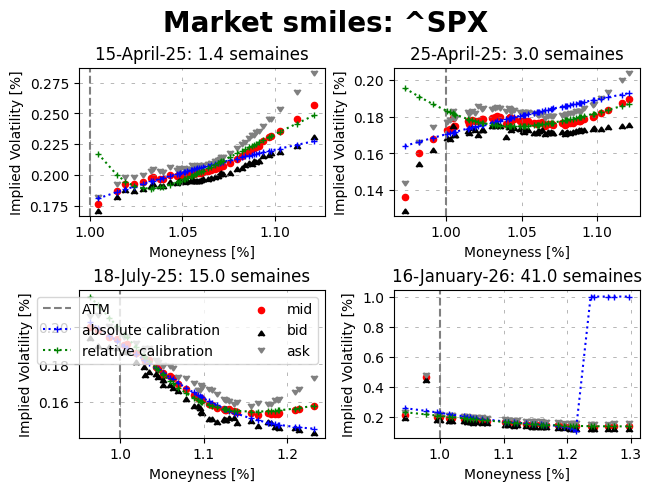

In [8]:
fig, axs = plt.subplots(2, 2, layout="constrained")
fig.suptitle(f'Market smiles: {symbol}', **fontdict_title)

############################################################
##### Absolute
############################################################
for maturity, ax in zip(considered_maturities, axs.flatten()):

    print("="*80)
    print(maturity)
    print("="*80,"\n")

    ####################################
    ### Getting and filtering data 
    ####################################

    full_market_data = filter_data_for_maturity(all_market_data, maturity)
    time_to_maturity = full_market_data['Time to Maturity'].iloc[0]
    strikes = full_market_data['Strike'].values
    bid_prices = full_market_data["Bid"].values
    ask_prices = full_market_data['Ask'].values
    market_ivs = full_market_data['Implied Volatility'].values
    market_prices = full_market_data['Call Price'].values

    marketVolatilitySmile = VolatilitySmile(
        strikes=strikes,
        time_to_maturity=time_to_maturity,
        atm=spot,
        market_ivs=market_ivs,
        r=r
    )
    market_data = marketVolatilitySmile.filters(full_market_data, select_mid_ivs=True)

    ####################################
    ### Calibration 
    ####################################
    heston = Heston(spot=spot, r=r, **params)
    initial_params = marketVolatilitySmile.calibration(
        price_function=heston.call_price,
        guess_correlation_sign='unknown',
        initial_guess=[params['kappa'], params['theta'], params['sigma'], params['rho']],
        speed='local',
    )

    # Absolute calibration
    calibrated_params = marketVolatilitySmile.calibration(
        relative_errors=False,
        price_function=heston.call_price,
        guess_correlation_sign='unknown',
        initial_guess=[initial_params['kappa'], initial_params['theta'], initial_params['sigma'], initial_params['rho']],
        speed='global',
        power='mse'
    )
    calibrated_prices = heston.call_price(
        strike=marketVolatilitySmile.strikes, time_to_maturity=time_to_maturity, **calibrated_params
    )
    print(marketVolatilitySmile.evaluate_calibration(calibrated_prices, 'price'))
    calibrated_ivs = marketVolatilitySmile.compute_smile(prices=calibrated_prices)
    print(marketVolatilitySmile.evaluate_calibration(calibrated_ivs, 'iv'))

    # Relative calibration
    calibrated_params_relative = marketVolatilitySmile.calibration(
        relative_errors=True,
        price_function=heston.call_price,
        guess_correlation_sign='negative',
        initial_guess=[initial_params['kappa'], initial_params['theta'], initial_params['sigma'], initial_params['rho']],
        speed='global',
        power='mse'
    )
    calibrated_prices_relative = heston.call_price(
        strike=marketVolatilitySmile.strikes, time_to_maturity=time_to_maturity, **calibrated_params_relative
    )
    print(marketVolatilitySmile.evaluate_calibration(calibrated_prices_relative, 'price'))
    calibrated_ivs_relative = marketVolatilitySmile.compute_smile(prices=calibrated_prices_relative)
    print(marketVolatilitySmile.evaluate_calibration(calibrated_ivs_relative, 'iv'))

    # Some plots
    ask_ivs = market_data['Ask ivs'].values
    bid_ivs = market_data['Bid ivs'].values
    forward = marketVolatilitySmile.atm * np.exp(marketVolatilitySmile.r * marketVolatilitySmile.time_to_maturity)

    if ax == axs.flatten()[-2]:
        ax.axvline(1, linestyle="--", color="gray", label="ATM")
        ax.plot(marketVolatilitySmile.strikes / forward, calibrated_ivs, label="absolute calibration", marker='+', color='blue', linestyle="dotted", markersize=4)
        ax.plot(marketVolatilitySmile.strikes / forward, calibrated_ivs_relative, label="relative calibration", marker='+', color='green', linestyle="dotted", markersize=4)
        ax.scatter(marketVolatilitySmile.strikes / forward, marketVolatilitySmile.market_ivs, label="mid", marker='o', color='red', s=20)
        ax.scatter(marketVolatilitySmile.strikes / forward, bid_ivs, label="bid", marker=6, color='black', s=20)
        ax.scatter(marketVolatilitySmile.strikes / forward, ask_ivs, label="ask", marker=7, color='gray', s=20)
        ax.legend(loc='upper right', ncol=2, alignment='left')
    else:
        ax.axvline(1, linestyle="--", color="gray")
        ax.plot(marketVolatilitySmile.strikes / forward, calibrated_ivs, marker='+', color='blue', linestyle="dotted", markersize=4)
        ax.plot(marketVolatilitySmile.strikes / forward, calibrated_ivs_relative, marker='+', color='green', linestyle="dotted", markersize=4)
        ax.scatter(marketVolatilitySmile.strikes / forward, marketVolatilitySmile.market_ivs, marker='o', color='red', s=20)
        ax.scatter(marketVolatilitySmile.strikes / forward, bid_ivs, marker=6, color='black', s=20)
        ax.scatter(marketVolatilitySmile.strikes / forward, ask_ivs, marker=7, color='gray', s=20)

    ax.set_xlabel("Moneyness [%]")
    ax.set_ylabel("Implied Volatility [%]")

    date = datetime.strptime(maturity, '%Y-%m-%d').date().strftime("%d-%B-%y")
    title = f"{date}: {marketVolatilitySmile.time_to_maturity * 252 / 5:.1f} semaines"
    ax.set_title(title)
    ax.grid(visible=True, which="major", linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5, alpha=0.8)

plt.show()